In [118]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [120]:
# use Seaborn theme
sns.set_theme()

EXP_PATH = '../runs'
PLOT_FOLDER = '.'

In [123]:
configs = {
    "task_name": "Door Opening",
    "file_name": "door_opening",
    "prefixes": ["Door-Panda-OSC", "Door-Sawyer-OSC", "Door-Panda-JOINT-VELOCITY", "Door-Sawyer-JOINT-VELOCITY"],
}

configs = {
    "task_name": "Block Lifting",
    "file_name": "block_lifting",
    "prefixes": ["Lift-Panda-OSC", "Lift-Sawyer-OSC", "Lift-Panda-JOINT-VELOCITY", "Lift-Sawyer-JOINT-VELOCITY"],
}

# configs = {
#     "task_name": "Block Stacking",
#     "file_name": "block_stacking",
#     "prefixes": ["Stack-Panda-OSC", "Stack-Sawyer-OSC"],
# }

# configs = {
#     "task_name": "Table Wiping",
#     "file_name": "table_wiping",
#     "prefixes": ["Wipe-Panda-OSC", "Wipe-Sawyer-OSC"],
# }

# configs = {
#     "task_name": "Nut Assembly Round",
#     "file_name": "nut_assembly_round",
#     "prefixes": ["NutAssemblyRound-Panda-OSC", "NutAssemblyRound-Sawyer-OSC"],
# }

# configs = {
#     "task_name": "Pick-and-Place Can",
#     "file_name": "pick_and_place_can",
#     "prefixes": ["PickPlaceCan-Panda-OSC", "PickPlaceCan-Sawyer-OSC"],
# }

# configs = {
#     "task_name": "Two Arm Handover",
#     "file_name": "two_arm_handover",
#     "prefixes": ["TwoArmHandoff-PandaPanda-OSC", "TwoArmHandoff-SawyerSawyer-OSC"],
# }

# configs = {
#     "task_name": "Two Arm Peg-in-Hole",
#     "file_name": "two_arm_peg_in_hole",
#     "prefixes": ["TwoArmPegInHole-PandaSawyer-OSC"],
# }

# configs = {
#     "task_name": "Two Arm Lifting",
#     "file_name": "two_arm_lifting",
#     "prefixes": ["TwoArmLift-PandaPanda-OSC", "TwoArmLift-SawyerSawyer-OSC"],
# }

In [122]:
# smoothing values
def smooth(values, weight):
    smoothed = np.array(values)
    for i in range(1, smoothed.shape[0]):
        smoothed[i] = smoothed[i-1] * weight + (1 - weight) * smoothed[i]
    return smoothed

Saving to ./block_lifting.pdf


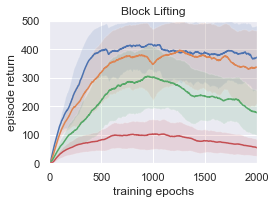

In [124]:
plt.figure(figsize=(4, 3))

handles = []
for exp_config in configs["prefixes"]:

    all_runs = os.listdir(EXP_PATH)

    runs = [x for x in all_runs if x.startswith(exp_config)]

    x = np.array(range(2000))

    returns_avg = []
    returns_std = []

    for r in runs:

        folder = os.listdir(os.path.join(EXP_PATH, r))
        assert len(folder) == 1

        df = pd.read_csv(os.path.join(EXP_PATH, r, folder[0], 'progress.csv'))
        r_mean = df['evaluation/Returns Mean'].to_numpy()
        r_std = df['evaluation/Returns Std'].to_numpy()

        returns_avg.append(r_mean)
        returns_std.append(r_std)
        
    weight = 0.99 # Yuke: modify smoothing weight here
    for idx, (means, stds) in enumerate(zip(returns_avg, returns_std)):
        returns_avg[idx] = smooth(means, weight)
        returns_std[idx] = smooth(stds, weight)

    y_range = (0, 500)

    returns_avg = np.array(returns_avg)
    returns_std = np.array(returns_std)

    y_mean = returns_avg.mean(0)
    y_std  = returns_std.mean(0)

    h, = plt.plot(x, y_mean)
    handles.append(h)

    confidence_min = y_mean - y_std
    confidence_max = y_mean + y_std

    plt.fill_between(x, confidence_min, confidence_max, alpha=0.15)

plt.xlabel('training epochs')
plt.ylabel('episode return')

plt.xlim(0, 2000)
plt.ylim(0, 500)

plt.title(configs["task_name"])

# plt.legend(
#     handles, 
#     ["Panda (OSC)", "Sawyer (OSC)", "Panda (Joint Velocity)", "Sawyer (Joint Velocity)"],
#     loc=(1.05, 0.56)
# )

plt.tight_layout()
file_name = os.path.join(PLOT_FOLDER, '%s.pdf' % configs["file_name"])
plt.savefig(file_name)

print('Saving to %s' % file_name)